In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/03 19:20:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import os

data_loc = "../data/tables/"
consumer = spark.read.parquet(data_loc+"consumer_user_details.parquet")
tbl_consumer = spark.read.csv(data_loc+"tbl_consumer.csv", sep="|", header=True)
tbl_merchant = spark.read.parquet(data_loc+"tbl_merchants.parquet")
transactions = [data_loc + i + "/" for i in os.listdir(data_loc) if "transactions" in i]
print(transactions)
transact = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot/')
transact = transact.union(spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot/'))
transact = transact.union(spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot/'))

['../data/tables/transactions_20210228_20210827_snapshot/', '../data/tables/transactions/', '../data/tables/transactions_20220228_20220828_snapshot/', '../data/tables/transactions_20210828_20220227_snapshot/']


<h2> 1. Standardize column format of tables</h2>

<h3>1.1 "tbl_merchants.parquet"</h3>

In [3]:
tbl_merchant.show(5)

+--------------------+--------------------+------------+
|                name|                tags|merchant_abn|
+--------------------+--------------------+------------+
|       Felis Limited|((furniture, home...| 10023283211|
|Arcu Ac Orci Corp...|([cable, satellit...| 10142254217|
|    Nunc Sed Company|([jewelry, watch,...| 10165489824|
|Ultricies Digniss...|([wAtch, clock, a...| 10187291046|
| Enim Condimentum PC|([music shops - m...| 10192359162|
+--------------------+--------------------+------------+
only showing top 5 rows



In [4]:
# separate "tags" into "products", "revenue_level", "take_rate"
preprocessed_tbl_merchant = tbl_merchant.withColumn("split_tags", split(col("tags"), ",")) \
            .withColumn("take_rate", element_at(col("split_tags"), -1)) \
            .withColumn("revenue_level", element_at(col("split_tags"), -2)) \
            .withColumn("products", slice(reverse(col("split_tags")), 3, 100)) \
            .withColumn("products", reverse(col("products")))

In [5]:
# remove the special characters of "revenue_level" and "take_rate"
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumn("revenue_level", regexp_replace("revenue_level", "[^a-e]", "")) \
                                                     .withColumn("take_rate", regexp_replace("take_rate", "[^0-9.]", ""))

In [6]:
# standardize the values in "products" and vectorize "products" into the bags of word
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumn("products", concat_ws(",", col("products"))) \
                                                     .withColumn("products", regexp_replace("products", "[^A-Za-z0-9]", " ")) \
                                                     .withColumn("products", regexp_replace("products", "\s+", " ")) \
                                                     .withColumn("products", regexp_replace("products", "(^\s+)|(\s+$)", "")) \
                                                     .withColumn("products", lower(col("products"))) \
                                                    #  .withColumn("products", split(col("products"), " "))

In [7]:
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumnRenamed("name", "merchant_name")
preprocessed_tbl_merchant = preprocessed_tbl_merchant.select("merchant_name", "products", "revenue_level",
                                                             preprocessed_tbl_merchant.take_rate.cast("double"), "merchant_abn")

In [8]:
preprocessed_tbl_merchant.show(5)

+--------------------+--------------------+-------------+---------+------------+
|       merchant_name|            products|revenue_level|take_rate|merchant_abn|
+--------------------+--------------------+-------------+---------+------------+
|       Felis Limited|furniture home fu...|            e|     0.18| 10023283211|
|Arcu Ac Orci Corp...|cable satellite a...|            b|     4.22| 10142254217|
|    Nunc Sed Company|jewelry watch clo...|            b|      4.4| 10165489824|
|Ultricies Digniss...|watch clock and j...|            b|     3.29| 10187291046|
| Enim Condimentum PC|music shops music...|            a|     6.33| 10192359162|
+--------------------+--------------------+-------------+---------+------------+
only showing top 5 rows



In [9]:
tags = preprocessed_tbl_merchant.rdd.map(lambda x: x[1]).collect()
tags_unique = " ".join(tags).split()
tags_unique = list(set(tags_unique))
print(len(tags_unique)) # not too many, can check some by hand, e.g. 'except' is the only word that has negative meaning
tags_unique

95


['florists',
 'novelty',
 'home',
 'periodicals',
 'software',
 'systems',
 'services',
 'antique',
 'supplies',
 'souvenir',
 'card',
 'appliance',
 'bicycle',
 'watch',
 'garden',
 'sales',
 'digital',
 'repairs',
 'repair',
 'sheet',
 'furniture',
 'art',
 'paper',
 'stock',
 'nursery',
 'silverware',
 'manufacturers',
 'craft',
 'shops',
 'outlets',
 'hobby',
 'goods',
 'gift',
 'except',
 'cable',
 'peripheral',
 'service',
 'radio',
 'furnishings',
 'toy',
 'eyeglasses',
 'telecom',
 'tool',
 'galleries',
 'flowers',
 'computer',
 'design',
 'including',
 'game',
 'printing',
 'beauty',
 'programming',
 'books',
 'data',
 'nurseries',
 'opticians',
 'instruments',
 'integrated',
 'processing',
 'supply',
 'pay',
 'satellite',
 'music',
 'lawn',
 'rent',
 'office',
 'and',
 'stationery',
 'awning',
 'optical',
 'shoe',
 'new',
 'health',
 'clock',
 'equipment',
 'spas',
 'movies',
 'jewelry',
 'vehicle',
 'parts',
 'television',
 'dealers',
 'musical',
 'restoration',
 'newspapers

In [10]:
tags_tok = tags
for i in range(len(tags)):
    tags_tok[i] = tags_tok[i].split()
    cur = [tags_tok[i][0]]
    for j in range(1, len(tags_tok[i])):
        if tags_tok[i][j-1] != "except":
            if tags_tok[i][j] not in ["and", "except", "other", "shops", "services"]:
                cur += [tags_tok[i][j]]
    tags_tok[i] = cur
# tags_tok

In [11]:
tags_tok_unique = []
for i in tags_tok:
    if i not in tags_tok_unique:
        tags_tok_unique += [i]
print(len(tags_tok_unique)) # only 25 unique ones, can categorise manually
tags_tok_unique

25


[['furniture', 'home', 'furnishings', 'equipment', 'manufacturers'],
 ['cable', 'satellite', 'pay', 'television', 'radio'],
 ['jewelry', 'watch', 'clock', 'silverware'],
 ['watch', 'clock', 'jewelry', 'repair'],
 ['music', 'musical', 'instruments', 'pianos', 'sheet', 'music'],
 ['gift', 'card', 'novelty', 'souvenir'],
 ['computers', 'computer', 'peripheral', 'equipment', 'software'],
 ['computer',
  'programming',
  'data',
  'processing',
  'integrated',
  'systems',
  'design'],
 ['equipment', 'tool', 'furniture', 'appliance', 'rent', 'al', 'leasing'],
 ['artist', 'supply', 'craft'],
 ['florists', 'supplies', 'nursery', 'stock', 'flowers'],
 ['antique', 'sales', 'repairs', 'restoration'],
 ['motor', 'vehicle', 'supplies', 'new', 'parts'],
 ['books', 'periodicals', 'newspapers'],
 ['stationery', 'office', 'supplies', 'printing', 'writing', 'paper'],
 ['tent', 'awning'],
 ['art', 'dealers', 'galleries'],
 ['bicycle', 'sales', 'service'],
 ['digital', 'goods', 'books', 'movies', 'music'

In [12]:
import collections

categories = [
    'home and technology', 'home and technology', 'fashion and accessories', 'fashion and accessories', 'books and music',
    'art and gifts', 'home and technology', 'home and technology', 'home and technology', 'art and gifts',
    'outdoors', 'art and gifts', 'outdoors', 'books and music', 'books and music',
    'outdoors', 'art and gifts', 'outdoors', 'books and music', 'fashion and accessories',
    'fashion and accessories', 'fashion and accessories', 'books and music', 'outdoors', 'home and technology'
]

tag_to_cat = {" ".join(tags_tok_unique[i]): categories[i] for i in range(len(categories))}
cat_list = [tag_to_cat[" ".join(i)] for i in tags_tok]

collections.Counter([i for i in cat_list]).most_common()

[('home and technology', 988),
 ('outdoors', 832),
 ('books and music', 829),
 ('fashion and accessories', 761),
 ('art and gifts', 616)]

In [13]:
from pyspark.sql.types import *

@udf(ArrayType(StringType()))
def tokenise(tag):
    tag = tag.split()
    cur = [tag[0]]
    for i in range(1, len(tag)):
        if tag[i-1] != "except":
            if tag[i] not in ["and", "except", "other", "shops", "services"]:
                cur += [tag[i]]
    return cur

@udf(StringType())
def categorise(tag):
    tag = " ".join(tag)
    return tag_to_cat[tag]

In [14]:
preprocessed_tbl_merchant_token = preprocessed_tbl_merchant.withColumn("tag", tokenise(col("products")))
preprocessed_tbl_merchant_cat = preprocessed_tbl_merchant_token.withColumn("category", categorise(col("tag")))
preprocessed_tbl_merchant_cat = preprocessed_tbl_merchant_cat.drop("tag")
preprocessed_tbl_merchant_cat

merchant_name,products,revenue_level,take_rate,merchant_abn,category
Felis Limited,furniture home fu...,e,0.18,10023283211,home and technology
Arcu Ac Orci Corp...,cable satellite a...,b,4.22,10142254217,home and technology
Nunc Sed Company,jewelry watch clo...,b,4.4,10165489824,fashion and acces...
Ultricies Digniss...,watch clock and j...,b,3.29,10187291046,fashion and acces...
Enim Condimentum PC,music shops music...,a,6.33,10192359162,books and music
Fusce Company,gift card novelty...,a,6.34,10206519221,art and gifts
Aliquam Enim Inco...,computers compute...,b,4.32,10255988167,home and technology
Ipsum Primis Ltd,watch clock and j...,c,2.39,10264435225,fashion and acces...
Pede Ultrices Ind...,computer programm...,a,5.71,10279061213,home and technology
Nunc Inc.,furniture home fu...,a,6.61,10323485998,home and technology


<h3>1.2 "transactions_20210228_20210827_snapshot"</h3>

In [15]:
transact.show(5)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 5 rows



In [16]:
# separate pickup datetime into date, year, month and day
preprocessed_transact = transact.withColumn('order_year', year(col('order_datetime')))
preprocessed_transact = preprocessed_transact.withColumn('order_month', month(col('order_datetime')))
preprocessed_transact = preprocessed_transact.withColumn('order_day', dayofmonth(col('order_datetime')))
preprocessed_transact = preprocessed_transact.withColumnRenamed('merchant_abn', 'merchant_abn_repeat')

In [17]:
preprocessed_transact.show(5)

+-------+-------------------+------------------+--------------------+--------------+----------+-----------+---------+
|user_id|merchant_abn_repeat|      dollar_value|            order_id|order_datetime|order_year|order_month|order_day|
+-------+-------------------+------------------+--------------------+--------------+----------+-----------+---------+
|  18478|        62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|      2021|          8|       20|
|      2|        15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|      2021|          8|       20|
|  18479|        64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|      2021|          8|       20|
|      3|        60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|      2021|          8|       20|
|  18479|        94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|      2021|          8|       20|
+-------+-------------------+------------------+--------

<h3>1.3 "tbl_consumer.csv"</h3>

In [18]:
tbl_consumer.show(5)

+-----------------+--------------------+-----+--------+------+-----------+
|             name|             address|state|postcode|gender|consumer_id|
+-----------------+--------------------+-----+--------+------+-----------+
| Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|    1195503|
|       Mary Smith|     3764 Amber Oval|  NSW|    2782|Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|   NT|     862|Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|  NSW|    2780|Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|   WA|    6355|Female|     712975|
+-----------------+--------------------+-----+--------+------+-----------+
only showing top 5 rows



In [19]:
preprocessed_tbl_consumer = tbl_consumer.withColumnRenamed("name", "consumer")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("address", "consumer_address")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("state", "consumer_state")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("postcode", "consumer_postcode")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("gender", "consumer_gender")

In [20]:
preprocessed_tbl_consumer.show(5)

+-----------------+--------------------+--------------+-----------------+---------------+-----------+
|         consumer|    consumer_address|consumer_state|consumer_postcode|consumer_gender|consumer_id|
+-----------------+--------------------+--------------+-----------------+---------------+-----------+
| Yolanda Williams|413 Haney Gardens...|            WA|             6935|         Female|    1195503|
|       Mary Smith|     3764 Amber Oval|           NSW|             2782|         Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|            NT|              862|         Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|           NSW|             2780|         Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|            WA|             6355|         Female|     712975|
+-----------------+--------------------+--------------+-----------------+---------------+-----------+
only showing top 5 rows



<h3>1.4 "consumer.parquet"</h3>

In [21]:
consumer.show(5)

+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
|      3|    1194530|
|      4|     154128|
|      5|     712975|
+-------+-----------+
only showing top 5 rows



In [22]:
preprocessed_consumer = consumer.withColumnRenamed("user_id", "user_id_repeat")
preprocessed_consumer = preprocessed_consumer.withColumnRenamed("consumer_id", "consumer_id_repeat")

In [23]:
preprocessed_consumer.show(5)

+--------------+------------------+
|user_id_repeat|consumer_id_repeat|
+--------------+------------------+
|             1|           1195503|
|             2|            179208|
|             3|           1194530|
|             4|            154128|
|             5|            712975|
+--------------+------------------+
only showing top 5 rows



<h2>2. Join tables</h2>

In [24]:
preprocessed_tbl_merchant_cat.createOrReplaceTempView('merchant')
preprocessed_transact.createOrReplaceTempView('transact')
preprocessed_tbl_consumer.createOrReplaceTempView('tbl_consumer')
preprocessed_consumer.createOrReplaceTempView('consumer')

join = spark.sql("""
SELECT 
    *
FROM 
    merchant
INNER JOIN
    transact
ON 
    transact.merchant_abn_repeat = merchant.merchant_abn
INNER JOIN
    consumer
ON
    transact.user_id = consumer.user_id_repeat
INNER JOIN
    tbl_consumer
ON 
    consumer.consumer_id_repeat = tbl_consumer.consumer_id
ORDER BY
    revenue_level DESC
""")

join = join.drop("merchant_abn_repeat", "consumer_id_repeat", "user_id_repeat", "merchant_abn", "consumer_id", "order_id")
print(f"Mismatched (null) transactions dropped: {preprocessed_transact.count() - join.count()}")

Mismatched (null) transactions dropped: 580830


In [25]:
join

merchant_name,products,revenue_level,take_rate,category,user_id,dollar_value,order_datetime,order_year,order_month,order_day,consumer,consumer_address,consumer_state,consumer_postcode,consumer_gender
Pellentesque Ut I...,watch clock and j...,e,0.38,fashion and acces...,895,38.82438474565778,2022-03-12,2022,3,12,Adrian Miller,9377 Douglas Inle...,SA,5572,Male
Nunc Est LLP,watch clock and j...,e,0.22,fashion and acces...,8838,31.377133626975795,2021-08-29,2021,8,29,Sabrina Perez,041 John Meadow S...,NSW,2739,Female
Suscipit LLC,computer programm...,e,0.3,home and technology,895,83.2513825984199,2021-10-01,2021,10,1,Adrian Miller,9377 Douglas Inle...,SA,5572,Male
Felis Limited,furniture home fu...,e,0.18,home and technology,3471,212.8573179553598,2021-05-02,2021,5,2,Todd Long,883 Patty Mountai...,NSW,2021,Male
Et Nunc Consulting,books periodicals...,e,0.16,books and music,12051,34.10819427488384,2021-07-30,2021,7,30,Aaron Harvey,35273 Powell Over...,TAS,7171,Male
Nullam Enim Sed I...,tent and awning s...,e,0.27,outdoors,3471,24.224444988836556,2021-07-29,2021,7,29,Todd Long,883 Patty Mountai...,NSW,2021,Male
Et Nunc Consulting,books periodicals...,e,0.16,books and music,12051,298.87055406882854,2021-05-05,2021,5,5,Aaron Harvey,35273 Powell Over...,TAS,7171,Male
Nunc Est LLP,watch clock and j...,e,0.22,fashion and acces...,3471,110.82143827510362,2022-06-22,2022,6,22,Todd Long,883 Patty Mountai...,NSW,2021,Male
Nunc Est LLP,watch clock and j...,e,0.22,fashion and acces...,12051,94.47243574996732,2021-07-12,2021,7,12,Aaron Harvey,35273 Powell Over...,TAS,7171,Male
Et Nunc Consulting,books periodicals...,e,0.16,books and music,3471,155.4258076824775,2021-10-20,2021,10,20,Todd Long,883 Patty Mountai...,NSW,2021,Male


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

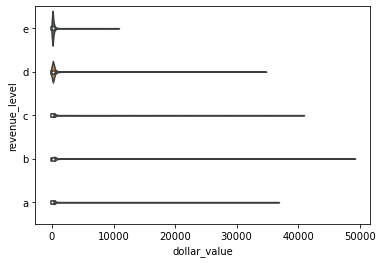

In [26]:
import seaborn as sns
sns.violinplot(data=join.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

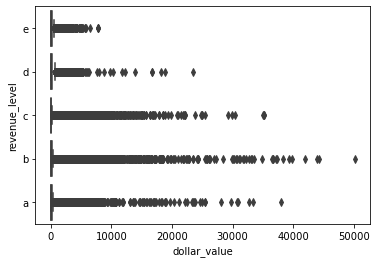

In [27]:
sns.boxplot(data=join.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

<h4>3.1.1 Remove outliers based on standard deviation</h4>

In [28]:
rev_std = (join.groupBy("revenue_level").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                             avg("dollar_value").alias("dollar_value_mean")))
rev_std

revenue_level,dollar_value_std,dollar_value_mean
e,399.0613152439408,205.8121276388132
d,681.0178374382781,272.26155837560833
c,434.4194205501614,136.49983808642475
b,594.2473799043438,197.1016706119255
a,360.36435354274346,142.08113719400276


In [29]:
total = join.count()
rev_sdf = (join.join(rev_std, "revenue_level", "left")
               .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
               .drop("dollar_value_mean")
               .drop("dollar_value_std"))
print(f"Outliers based on revenue band removed: {total - rev_sdf.count()}")

Outliers based on revenue band removed: 136394


<h4>3.1.2 Check distribution</h4>

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

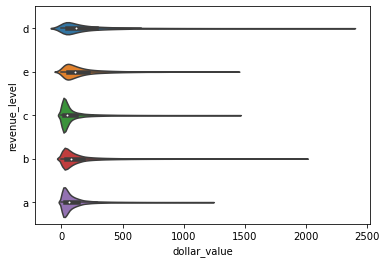

In [30]:
sns.violinplot(data=rev_sdf.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

22/10/03 19:24:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

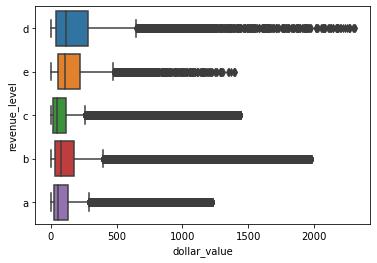

In [31]:
sns.boxplot(data=rev_sdf.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

<h3>3.2 Get distribution of each merchant</h3>

In [32]:
merch_std = (rev_sdf.groupBy("merchant_name").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                                  avg("dollar_value").alias("dollar_value_mean")))
merch_std

22/10/03 19:24:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 19:24:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


merchant_name,dollar_value_std,dollar_value_mean
Donec Luctus Indu...,130.5565015716507,343.7164090501804
Elit Company,122.96176805496256,171.59405507134576
Aliquet Odio Ltd,525.5999084080495,989.9594869027516
Et Pede Inc.,354.5044546463389,718.4388984070839
Commodo Auctor Ve...,51.08175002355147,54.94036664642259
Hendrerit Consect...,323.0055122458617,328.12859457680736
Libero Nec Ligula...,287.0373760898241,708.8891167985263
Montes Nascetur Ltd,190.52722125221516,351.7849409696694
Ut Nisi Limited,552.0367734312347,648.2357732269966
Enim Etiam Institute,349.0376849678728,734.5491579179835


In [33]:
total = rev_sdf.count()
merch_sdf = (rev_sdf.join(merch_std, "merchant_name", "left")
                   .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
                   .drop("dollar_value_mean")
                   .drop("dollar_value_std"))
print(f"Outliers based on merchant removed: {total - merch_sdf.count()}")

22/10/03 19:24:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 19:24:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 19:24:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 19:24:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 19:24:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 19:24:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 19:24:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/03 19:25:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 19:25:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 19:25:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/03 19:25:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Outliers based on merchant removed: 175078


In [35]:
join.write.parquet("../data/curated/raw_join_internal_table")